# Transformer Tuning

This notebook is dedicated to tuning the transformer. 

In [1]:
# Importing libraries and classes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
import torch
from torch.utils.data import TensorDataset, DataLoader

# Adding the source code path to the notebook
import sys
sys.path.append('/Users/jinalshah/Jinal/Projects/nlp-disaster-tweets/src')

from preprocessing import Preprocessing
from transformer import Transformer

%matplotlib inline

In [2]:
# Importing the data
raw_train = pd.read_csv('../inputs/train.csv')

In [3]:
# Splitting the data into training, validation, and testing
training, testing = train_test_split(raw_train,test_size=0.2,random_state=42,shuffle=True,stratify=raw_train['target'])
validation, testing = train_test_split(testing,test_size=0.2,random_state=42,shuffle=True,stratify=testing['target'])
training.reset_index(drop=True,inplace=True)
validation.reset_index(drop=True,inplace=True)
testing.reset_index(drop=True,inplace=True)

In [4]:
# Splitting data into X & Y
train_x = training.drop(['target'],axis=1)
train_y = training['target'].values
valid_x = validation.drop(['target'],axis=1)
valid_y = validation['target'].values

In [5]:
# Getting the preprocessed text
preprocessor = Preprocessing()
preprocessed_train_x = preprocessor.preprocess_data(train_x)
preprocessed_valid_x = preprocessor.preprocess_data(valid_x)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jinalshah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Transforming data to (number of examples, 57, 1000)
training_X = []
valid_X = []

# Opening the vocabulary and marking 1 to indicate the word
with open('../mappers/word2index.json') as file:
    vocabulary = json.load(file)

    # Iterating through the training
    for sentence_index in range(0,len(preprocessed_train_x)):
        sentence_convert = [1001] * 57
        for word_index in range(0,len(preprocessed_train_x[sentence_index])):
            # If the word is in the vocab, get the index
            word = preprocessed_train_x[sentence_index][word_index]
            if word in vocabulary.keys():
                sentence_convert[word_index] = vocabulary[word]
            else:
                sentence_convert[word_index] = 1000
        
        training_X.append(sentence_convert)
    
    # Iterating through the validation
    for sentence_index in range(0,len(preprocessed_valid_x)):
        sentence_convert = [1001] * 57
        for word_index in range(0,len(preprocessed_valid_x[sentence_index])):
            # If the word is in the vocab, get the index
            word = preprocessed_valid_x[sentence_index][word_index]
            if word in vocabulary.keys():
                sentence_convert[word_index] = vocabulary[word]
            else:
                sentence_convert[word_index] = 1000

        valid_X.append(sentence_convert)

train_X = torch.from_numpy(np.array(training_X))
valid_X = torch.from_numpy(np.array(valid_X))
train_y = torch.from_numpy(train_y)
valid_y = torch.from_numpy(valid_y)

In [7]:
training_dataset = TensorDataset(train_X,train_y)
validation_dataset = TensorDataset(valid_X,valid_y)

# Storing the training and validation data in DataLoaders
training_loader = DataLoader(training_dataset,batch_size=64,shuffle=True)
validation_loader = DataLoader(validation_dataset,batch_size=64,shuffle=True)

In [8]:
# Creating an array for the model metrics
training_metrics = []
validation_metrics = []

# Creating a function that returns the metrics
def get_metrics(truth,predictions):
    f1 = f1_score(truth,predictions)
    precision = precision_score(truth,predictions)
    recall = recall_score(truth,predictions)
    accuracy = accuracy_score(truth,predictions)
    return f1, precision, recall, accuracy

In [9]:
# A function for the training loop
def training_loop(model,loss_fn,optimizer,training_data):
    size = len(training_data.dataset)
    model.train() # Setting the model to training mode

    # Iterating through the batches
    for batch , (X,y) in enumerate(training_data):
        # Compute the predictions
        pred = model(X)

        # Calculate the loss
        loss = loss_fn(pred,y)

        # Calculate the derivatives (backpropagation)
        loss.backward()

        # Take a step with the optimizer
        optimizer.step()

        # Reset the gradients
        optimizer.zero_grad()

        # Printing out the progress for every 20 batches
        if batch % 20 == 0:
            loss, current = loss.item(), (batch+1) * len(X)
            print(f'loss :{loss} {round(current/size,2)*100}% Complete')

In [10]:
def predict(model, data):
    """
    predict

    Function to make the predictions

    inputs:
    - model: PyTorch model
    - data: a PyTorch dataloader

    Returns:
    - average_loss: Average loss per example in the dataset
    """
    model.eval()  # Set the model to evaluation mode
    predictions = []
    truth = []

    with torch.no_grad(): # Setting torch to no grad so that the PyTorch doesn't calculate gradients
        for X, y in data:
            preds = model(X)  # Forward pass
            predictions.extend(preds.numpy())
            truth.extend(y.numpy())
    return np.array(predictions), np.array(truth)

In [50]:
# Training the model
model = Transformer(embed_dim=204,heads=4,dropout_rate=0.4)
epochs = 30
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
loss_function = torch.nn.CrossEntropyLoss()
train_history = []
valid_history = []
f1_train = []
f1_valid = []

# Printing out the model
model

Transformer(
  (embedding): Embedding(1002, 204)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=204, out_features=204, bias=True)
  )
  (layernorm1): LayerNorm((204,), eps=1e-05, elementwise_affine=True)
  (atten_output): Linear(in_features=204, out_features=204, bias=True)
  (final_atten_output): Linear(in_features=204, out_features=204, bias=True)
  (layernorm2): LayerNorm((204,), eps=1e-05, elementwise_affine=True)
  (clf_output_one): Linear(in_features=204, out_features=50, bias=True)
  (output): Linear(in_features=50, out_features=2, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [51]:
# Training the model
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}\n-------------------------------')
    training_loop(model,loss_function,optimizer,training_loader)
    training_pred, truth = predict(model,training_loader)
    loss = loss_function(torch.from_numpy(training_pred),torch.from_numpy(truth))
    train_history.append(loss.item())
    f1_training = f1_score(truth,np.argmax(training_pred,axis=1),zero_division=0.0)
    f1_train.append(f1_training)

    # Validation portion
    valid_pred, truth = predict(model,validation_loader)
    loss = loss_function(torch.from_numpy(valid_pred),torch.from_numpy(truth))
    valid_history.append(loss.item())
    f1_validation = f1_score(truth,np.argmax(valid_pred,axis=1),zero_division=0.0)
    f1_valid.append(f1_validation)
    print()

Epoch 1
-------------------------------
loss :0.6934975385665894 1.0% Complete
loss :0.6908199191093445 22.0% Complete
loss :0.6821685433387756 43.0% Complete
loss :0.669417142868042 64.0% Complete
loss :0.6869151592254639 85.0% Complete

Epoch 2
-------------------------------
loss :0.6812699437141418 1.0% Complete
loss :0.6924908757209778 22.0% Complete
loss :0.6801609396934509 43.0% Complete
loss :0.6807384490966797 64.0% Complete
loss :0.6498855352401733 85.0% Complete

Epoch 3
-------------------------------
loss :0.6839757561683655 1.0% Complete
loss :0.6565674543380737 22.0% Complete
loss :0.6493591666221619 43.0% Complete
loss :0.6238529086112976 64.0% Complete
loss :0.6912687420845032 85.0% Complete

Epoch 4
-------------------------------
loss :0.7039644122123718 1.0% Complete
loss :0.6717112064361572 22.0% Complete
loss :0.6552526354789734 43.0% Complete
loss :0.6605238914489746 64.0% Complete
loss :0.6700595021247864 85.0% Complete

Epoch 5
-------------------------------
l

In [52]:
training_predictions, y_true = predict(model,training_loader)
validation_predictions, y_val = predict(model,validation_loader)
train_metrics = get_metrics(y_true,np.argmax(training_predictions,axis=1))
valid_metrics = get_metrics(y_val,np.argmax(validation_predictions,axis=1))
train_metrics_df = {'Name':'Transformer','F1':train_metrics[0],'Precision':train_metrics[1],'Recall':train_metrics[2],'Accuracy':train_metrics[3]}
valid_metrics_df = {'Name':'Transformer','F1':valid_metrics[0],'Precision':valid_metrics[1],'Recall':valid_metrics[2],'Accuracy':valid_metrics[3]}

In [53]:
# Viewing training metrics
train_metrics_df

{'Name': 'Transformer',
 'F1': 0.7731337076315243,
 'Precision': 0.8480839416058394,
 'Recall': 0.7103553687428353,
 'Accuracy': 0.8208538587848933}

In [54]:
# Viewing validation metrics
valid_metrics_df

{'Name': 'Transformer',
 'F1': 0.7296747967479674,
 'Precision': 0.7787418655097614,
 'Recall': 0.6864244741873805,
 'Accuracy': 0.7816091954022989}

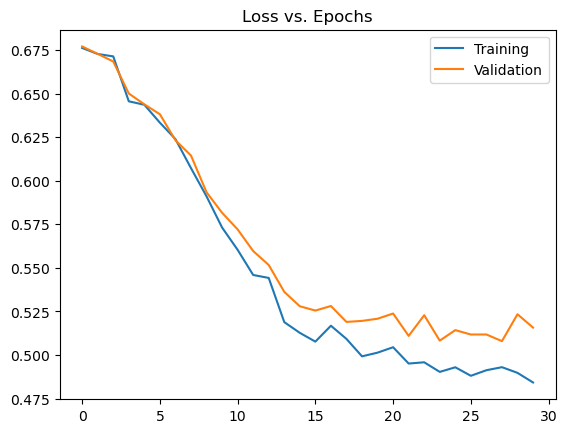

In [55]:
# Plotting the learning curve
plt.title('Loss vs. Epochs')
plt.plot(train_history,label='Training')
plt.plot(valid_history,label='Validation')
plt.legend()
plt.show()

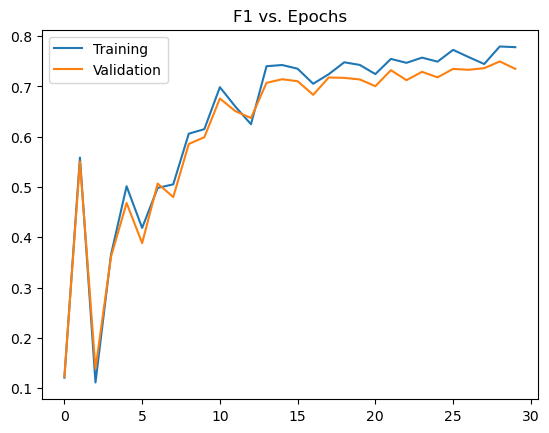

In [56]:
# Plotting the learning curve
plt.title('F1 vs. Epochs')
plt.plot(f1_train,label='Training')
plt.plot(f1_valid,label='Validation')
plt.legend()
plt.show()

In [42]:
# Saving the model
torch.save(model.state_dict(),'../models/transformers200-4-0-4.pt')